In [1]:
import pprint

## Preparing the supervised dataset

In [2]:
import json
import os
import urllib
def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()
    with open(file_path, "r") as file:
        data = json.load(file)
    return data
    
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:")
pprint.pprint(data[1])

Example entry:
{'input': 'He go to the park every day.',
 'instruction': 'Edit the following sentence for grammar.',
 'output': 'He goes to the park every day.'}


In [4]:
print("Example entry:")
pprint.pprint(data[2])

Example entry:
{'input': '',
 'instruction': 'Convert 45 kilometers to meters.',
 'output': '45 kilometers is 45000 meters.'}


$\rightarrow$ **input can be optional**

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    return instruction_text + input_text

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


*Partioning the dataset*

In [7]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

Let's create our custom collate function used for batching

In [8]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


This custom collate function pads the training examples in each batch to the same length while allowing different batches to have different lengths

In [10]:
import torch
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100,
                        allowed_max_length=None, device="cpu"):

    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # Replaces all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
            
        # Optionally truncates to the maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

In [12]:
inputs, targets = custom_collate_fn(batch)
# print(inputs)
# print(targets)

**We take advantage of this ignore_index to ignore the additional end-of-text (padding) tokens
that we used to pad the training examples to have the same length in each batch.**

**However, we want to keep one 50256 (end-of-text) token ID in the targets because it
helps the LLM to learn to generate end-of-text tokens, which we can use as an indica-
tor that a response is complete.**

**By masking out the LLM’s target token IDs corresponding to the instruction, the cross
entropy loss is only computed for the generated response target IDs. Thus, the model
is trained to focus on generating accurate responses rather than memorizing instruc-
tions, which can help reduce overfitting.**

## Creating data loaders for an instruction dataset

In [13]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

# used to pre-fill (bind) some arguments of a function, creating a new function with fewer parameters.

from functools import partial
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)



In [14]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(42)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [15]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 91]) torch.

## Loading a pretrained LLM

In [18]:
from utils.gpt_download import download_and_load_gpt2
from utils.utils import GPTModel
from utils.utils import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}

model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="../../OpenAI-GPT/"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

/Users/dorian/AI/LLMFromScratch/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


File already exists and is up-to-date: ../../OpenAI-GPT/355M/checkpoint
File already exists and is up-to-date: ../../OpenAI-GPT/355M/encoder.json
File already exists and is up-to-date: ../../OpenAI-GPT/355M/hparams.json
File already exists and is up-to-date: ../../OpenAI-GPT/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../../OpenAI-GPT/355M/model.ckpt.index
File already exists and is up-to-date: ../../OpenAI-GPT/355M/model.ckpt.meta
File already exists and is up-to-date: ../../OpenAI-GPT/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [19]:
torch.manual_seed(42)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [20]:
from utils.utils import generate, text_to_token_ids, token_ids_to_text
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [21]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## Fine-tuning the LLM on instruction data

In [22]:
from utils.utils import calc_loss_loader, train_model_simple, evaluate_model

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
torch.manual_seed(42)

train_loss, val_loss = evaluate_model(
    model, train_loader, val_loader, device, eval_iter=5
)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)



Training loss: 3.8875033855438232
Validation loss: 3.7619349479675295


In [23]:
format_input(val_data[0])

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'"

In [24]:
import time
start_time = time.time()
torch.manual_seed(42)
print("Device:", device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.00005, weight_decay=0.1
)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Device: mps
Ep 1 (Step 000000): Train loss 2.544, Val loss 2.615
Ep 1 (Step 000005): Train loss 1.045, Val loss 1.117
Ep 1 (Step 000010): Train loss 0.942, Val loss 0.977
Ep 1 (Step 000015): Train loss 0.887, Val loss 0.933
Ep 1 (Step 000020): Train loss 0.800, Val loss 0.902
Ep 1 (Step 000025): Train loss 0.788, Val loss 0.867
Ep 1 (Step 000030): Train loss 0.683, Val loss 0.830
Ep 1 (Step 000035): Train loss 0.654, Val loss 0.802
Ep 1 (Step 000040): Train loss 0.654, Val loss 0.794
Ep 1 (Step 000045): Train loss 0.727, Val loss 0.775
Ep 1 (Step 000050): Train loss 0.682, Val loss 0.762
Ep 1 (Step 000055): Train loss 0.570, Val loss 0.753
Ep 1 (Step 000060): Train loss 0.663, Val loss 0.737
Ep 1 (Step 000065): Train loss 0.624, Val loss 0.728
Ep 1 (Step 000070): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.653, Val loss 0.731
Ep 1 (Step 000080): Train loss 0.528, Val loss 0.724
Ep 1 (Step 000085): Train loss 0.503, Val loss 0.714
Ep 1 (Step 000090): Train loss 0.4

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

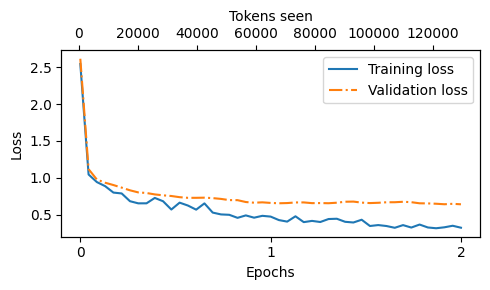

In [27]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Extracting and saving responses

In [29]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> Thunderstorms typically form in the atmosphere over the surface of the Earth. They typically are composed of electrically charged particles, typically nitrogen, oxygen, or carbon dioxide.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name 

*Generating test set responses for future evaluation*

In [30]:
from tqdm import tqdm
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
    generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )
    test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

Device: mps


100%|██████████| 110/110 [02:08<00:00,  1.17s/it]


In [33]:
pprint.pprint(test_data[0])

{'input': 'The car is very fast.',
 'instruction': 'Rewrite the sentence using a simile.',
 'model_response': 'The car is as fast as a cheetah.',
 'output': 'The car is as fast as lightning.'}


*saving model*

In [34]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


## Evaluating the fine-tuned LLM - LLM as a judge

### 1. Ollama running locally (llama.cpp)

### 2. VIA OpenAI API

In [4]:
import os
from openai import OpenAI

api_key = os.environ["OPENAI_API_KEY"]
client = OpenAI(api_key=api_key)

In [1]:
# def run_chatgpt(prompt, client, model="gpt-4o"):
#     response = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}],
#         temperature=0.0,
#         seed=123,
#     )
#     return response.choices[0].message.content


# prompt = "Respond with 'hello world' if you got this message."
# run_chatgpt(prompt, client)